In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/AIC_2023/BLIP/LAVIS
# !git clone https://github.com/salesforce/LAVIS.git
!pip install -r requirements.txt

/content/drive/MyDrive/AIC_2023/BLIP/LAVIS


In [5]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess

/usr/local/lib/python3.10/dist-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


### Load an example image

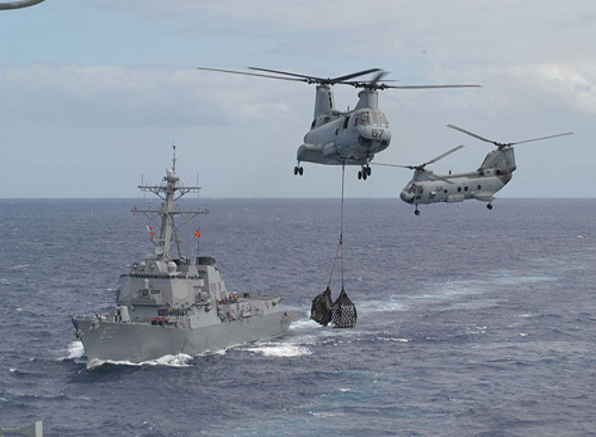

In [6]:
raw_image = Image.open("/content/drive/MyDrive/AIC_2023/BLIP/Img/20151027183327-tau4.jpg").convert("RGB")
display(raw_image.resize((596, 437)))

### Load BLIP feature extractor

In [7]:
model, vis_processors, txt_preprocess = load_model_and_preprocess("blip_feature_extractor", model_type="base", is_eval=True, device="cuda")

100%|██████████| 1.97G/1.97G [00:15<00:00, 140MB/s] 


### Specify class names

In [8]:
cls_names = ["motorbike", "sky", "helicopter", "mountain", "ship", "sea"]

# (optional) add prompt when we want to use the model for zero-shot classification
from lavis.processors.blip_processors import BlipCaptionProcessor
text_processor = BlipCaptionProcessor(prompt="A picture of ")

cls_prompt = [text_processor(cls_nm) for cls_nm in cls_names]

In [12]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device="cuda")

### Extract image embedding and class name embeddings

In [13]:
sample = {"image": image, "text_input": cls_names}

image_features = model.extract_features(sample, mode="image").image_embeds_proj[:, 0]
text_features = model.extract_features(sample, mode="text").text_embeds_proj[:, 0]

### Matching image embeddings with each class name embeddings

In [14]:
sims = (image_features @ text_features.t())[0] / model.temp
probs = torch.nn.Softmax(dim=0)(sims).tolist()

for cls_nm, prob in zip(cls_names, probs):
    print(f"{cls_nm}: \t {prob:.3%}")

motorbike: 	 0.050%
sky: 	 1.997%
helicopter: 	 71.952%
mountain: 	 0.027%
ship: 	 23.308%
sea: 	 2.665%
